# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [1]:
import scapy.all as scapy
# from netml.pparser.process_pcap import from_pcap
from netml.pparser.parser import PCAP
import pandas as pd
import os

pcap_file = 'netflix.pcap'
try:
    packets = scapy.rdpcap(pcap_file)
    print(f"Successfully loaded {len(packets)} packets from {pcap_file}")
except FileNotFoundError:
    print(f"Error: {pcap_file} not found")
except Exception as e:
    print(f"An error occurred loading the pcap: {e}")

/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/scapy/layers/ipsec.py:512: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  cipher=algorithms.TripleDES,
/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/scapy/layers/ipsec.py:516: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  cipher=algorithms.TripleDES,


Successfully loaded 141471 packets from netflix.pcap


In [2]:
# Seeing all domain names
import scapy.all as scapy

pcap_file = "netflix.pcap"
packets = scapy.rdpcap(pcap_file)

domains = set()
for pkt in packets:
    if pkt.haslayer(scapy.DNS) and pkt[scapy.DNS].qr == 0:  # DNS query
        try:
            domains.add(pkt[scapy.DNS].qd.qname.decode('utf-8').strip('.'))
        except:
            pass

print(f"Total unique domains: {len(domains)}")
for d in sorted(domains):
    print(d)


Total unique domains: 39
543458527._teamviewer._tcp.local
Diegos-MacBook-Air.local
_privet._tcp.local
accounts.google.com
adservice.google.fr
apis.google.com
assets.nflxext.com
codex.nflxext.com
customerevents.netflix.com
db._dns-sd._udp.0.43.168.192.in-addr.arpa
dr._dns-sd._udp.0.43.168.192.in-addr.arpa
fonts.gstatic.com
freegeoip.net
google.com
googleads.g.doubleclick.net
ipv4-c001-cdg001-ix.1.oca.nflxvideo.net
ipv4-c005-cdg001-ix.1.oca.nflxvideo.net
ipv4-c024-cdg001-ix.1.oca.nflxvideo.net
ipv4-c063-cdg001-ix.1.oca.nflxvideo.net
ipv4-c069-cdg001-ix.1.oca.nflxvideo.net
ipv4-c071-cdg001-ix.1.oca.nflxvideo.net
ipv4-c072-cdg001-ix.1.oca.nflxvideo.net
mpittoni-macbook._ftp._tcp.local
mpittoni-macbook._sftp-ssh._tcp.local
occ-0-56-55.1.nflxso.net
push.prod.netflix.com
r._dns-sd._udp.0.43.168.192.in-addr.arpa
r4---sn-gxo5uxg-jqbe.googlevideo.com
ssl.gstatic.com
tp-s.nflximg.net
update.googleapis.com
www.google.com
www.google.fr
www.googleadservices.com
www.gstatic.com
www.netflix.com
www.yo

### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [3]:
# Based on the domains observed, we can filter for Netflix-related traffic
netflix_domains = [
    "nflxvideo.net",
    "nflxext.com",
    "nflxso.net",
    "nflximg.net",
    "netflix.com"
]

netflix_ips = set()

# We only want to keep responses: DNS response (qr=1) with answers (ancount > 0)
for pkt in packets:
    if pkt.haslayer(scapy.DNS) and pkt[scapy.DNS].qr == 1 and pkt[scapy.DNS].ancount > 0:
        for i in range(pkt[scapy.DNS].ancount):
            answer = pkt[scapy.DNS].an[i]
            
            # I had to use Gemini to do this chunk.
            # Prompt: "In Scapy, how do I check if a DNS answer is an 'A' (IPv4) 
            # record and extract the domain name and IP address?"
            if answer.type == 1: # 'A' (IPv4) record
                domain = answer.rrname.decode('utf-8')
                if any(nd in domain for nd in netflix_domains):
                    netflix_ips.add(answer.rdata)

print(f"\nIdentified {len(netflix_ips)} Netflix-related IP addresses.")
print(netflix_ips)

# Get all packets related to Netflix IPs
netflix_packets = []
for pkt in packets:
    if pkt.haslayer(scapy.IP):
        # Keep packets where either source or destination IP is in netflix_ips
        if pkt[scapy.IP].src in netflix_ips or pkt[scapy.IP].dst in netflix_ips:
            netflix_packets.append(pkt)

print(f"\nFiltered down to {len(netflix_packets)} Netflix-related packets.")


filtered_pcap_file = 'netflix_only.pcap'
scapy.wrpcap(filtered_pcap_file, netflix_packets)
print(f"Saved filtered Netflix traffic to {filtered_pcap_file}")


Identified 15 Netflix-related IP addresses.
{'198.38.120.134', '52.210.19.176', '52.208.128.101', '198.38.120.167', '198.38.120.164', '34.252.77.54', '198.38.120.162', '52.48.8.150', '52.210.133.255', '198.38.120.137', '198.38.120.153', '52.19.39.146', '52.48.148.78', '198.38.120.166', '198.38.120.130'}

Filtered down to 138633 Netflix-related packets.
Saved filtered Netflix traffic to netflix_only.pcap


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [4]:
from netml.pparser.parser import PCAP
from netml.utils.tool import dump_data, load_data

pcap = PCAP('netflix_only.pcap', flow_ptks_thres=2)

pcap.pcap2flows()

# Extract inter-arrival time features
pcap.flow2features('IAT', fft=False, header=False)

iat_features = pcap.features

In [5]:
iat_features_df = pd.DataFrame(iat_features)
print(iat_features_df.head())

        0         1         2         3         4         5         6    \
0  0.714240  0.000158  1.207696  0.017828  0.001739  2.609759  0.001923   
1  0.715549  0.000191  1.286184  0.017959  0.002137  2.543728  0.002128   
2  0.713235  0.000234  1.128762  0.017737  0.001898  2.618819  0.002096   
3  0.768140  0.000545  2.326351  0.015718  0.001761  1.712796  0.981150   
4  0.771010  0.000206  2.449168  0.017225  0.002280  1.603454  0.987820   

        7             8         9    ...  925  926  927  928  929  930  931  \
0  1.369284  7.958562e+00  0.557696  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  9.313323  5.603709e-01  0.001295  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  1.425096  7.973116e+00  0.555151  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.021840  9.536743e-07  0.541786  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  3.662901  9.536743e-07  0.582064  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   932  933  934  
0  0.0  0.0  0.0  
1  0.0  0.0  0.0  
2  0.0  0.0  0.0 

In [6]:
# Extract statistical features
pcap.flow2features('STATS', fft=False, header=False)
stats_features = pcap.features

# Extract sampled-bytes features
pcap.flow2features('SAMP_SIZE', fft=False, header=False)
samp_size_features = pcap.features


In [7]:
stat_features_df = pd.DataFrame(stats_features)
samp_size_features_df = pd.DataFrame(samp_size_features)
print(stat_features_df.head())

           0         1           2           3          4     5     6      7   \
0   14.440177  0.831015   73.683308   88.666667  48.140997  66.0  66.0   69.0   
1   14.442865  0.761622   69.099863   90.727273  49.772374  66.0  66.0   72.0   
2   14.437420  0.831173   73.697377   88.666667  48.140997  66.0  66.0   69.0   
3  138.854511  1.497971  184.560082  123.206731  66.443951  66.0  66.0  200.0   
4   74.817607  0.360878   45.203263  125.259259  66.350692  66.0  66.0  200.0   

     8      9      10       11  
0  66.0  200.0   12.0   1064.0  
1  66.0  200.0   11.0    998.0  
2  66.0  200.0   12.0   1064.0  
3  54.0  200.0  208.0  25627.0  
4  54.0  200.0   27.0   3382.0  


**Write a brief justification for the features that you have chosen.**

I chose the **STATS** represenation after I used the netml library to extract different types of network features from the Netflix traffic flows. The STATS representation is chosen because it provides useful summary statistics for each flow (packet rate, byte rate, packet size statistics, total packets, and total bytes). These are easy to feed into a model.
I also experimented with IAT (inter-arrival times) and SAMP_SIZE (per-interval byte counts) to capture traffic burstiness, which is often correlated with video segment downloads and playback quality.

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [26]:
try:
    pcap.flow2features('SAMP_SIZE', fft=False, header=False, delta_t=1.0) 
except TypeError:
    pcap.flow2features('SAMP_SIZE', fft=False, header=False)
    print("Note: Using default delta_t as your netml version does not support specifying it.")

samp_features = pcap.features
df_samp = pd.DataFrame(samp_features)



Note: Using default delta_t as your netml version does not support specifying it.


In [27]:
import numpy as np

# Saw Chase's slack message defining segment rate with gaps
def count_segments_gap_nothresh(row):
    arr = row.values.astype(float)
    active = arr > 0  # only care if there's traffic in that second
    starts = active & ~np.roll(active, 1)
    starts[0] = active[0]  # handle the first interval
    return int(starts.sum())

# Count segments for each flow
segment_counts_gap = df_samp.apply(count_segments_gap_nothresh, axis=1)

# Convert to rate per second
n_windows = df_samp.shape[1]
delta_t = 1.0  # default for netml SAMP_SIZE
segment_rate_gap = segment_counts_gap / (n_windows * delta_t)

# Add to feature dataframe
stat_features_df["segment_rate_gap"] = segment_rate_gap


In [28]:
# Top flows by max bytes in any 1s window
top_idx = df_samp.max(axis=1).sort_values(ascending=False).head(5).index
for i in top_idx:
    row = df_samp.loc[i]
    active = row.values > threshold
    starts = active & ~np.roll(active, 1)
    starts[0] = active[0]
    print(f"\n--- Row {i} ---")
    print("max_window_bytes:", int(row.max()))
    print("first_40_bytes  :", row.values[:40])
    print("active[:40]     :", active[:40])
    print("starts[:40]     :", starts[:40])
    print("segments_count  :", int(starts.sum()))



--- Row 80 ---
max_window_bytes: 1388200
first_40_bytes  : [1282623.  271600.    4800.   17400.   14000.  258800. 1388200.  439000.
  688177.  428000.  720739.  553600.  440200.  117800.   27600.   27600.
   27600.   27600.   13598.   31600.   25200.   21000.   39600.   37200.
   18200.    9932.   46122.       0.       0.       0.       0.       0.
       0.       0.       0.       0.       0.       0.       0.       0.]
active[:40]     : [ True  True False False False  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
starts[:40]     : [ True False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
segments_count  : 2

--- Row 65 ---
max_window_b

## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [29]:
import os
import pandas as pd
import numpy as np

pkl_path = "netflix_dataset.pkl"
if not os.path.exists(pkl_path) and os.path.exists("netflix_dataset.pkl.zip"):
    import zipfile
    with zipfile.ZipFile("netflix_dataset.pkl.zip", "r") as zf:
        zf.extractall(".")
assert os.path.exists(pkl_path), "netflix_dataset.pkl not found"
data = pd.read_pickle(pkl_path)
print("Loaded:", data.shape)


Loaded: (52279, 251)


In [37]:
print(data.columns.tolist())


['10_EWMA_chunksizes', '10_avg_chunksize', '10_chunksizes_50', '10_chunksizes_50R', '10_chunksizes_75', '10_chunksizes_75R', '10_chunksizes_85', '10_chunksizes_85R', '10_chunksizes_90', '10_chunksizes_90R', '10_max_chunksize', '10_min_chunksize', '10_std_chunksize', 'absolute_timestamp', 'access_50_perc', 'access_75_perc', 'access_avg', 'access_max', 'access_min', 'access_stddev', 'access_var', 'ads', 'all_prev_down_chunk_iat_50', 'all_prev_down_chunk_iat_50R', 'all_prev_down_chunk_iat_75', 'all_prev_down_chunk_iat_75R', 'all_prev_down_chunk_iat_85', 'all_prev_down_chunk_iat_85R', 'all_prev_down_chunk_iat_90', 'all_prev_down_chunk_iat_90R', 'all_prev_down_chunk_iat_avg', 'all_prev_down_chunk_iat_max', 'all_prev_down_chunk_iat_min', 'all_prev_down_chunk_iat_std', 'all_prev_up_chunk_iat_50', 'all_prev_up_chunk_iat_50R', 'all_prev_up_chunk_iat_75', 'all_prev_up_chunk_iat_75R', 'all_prev_up_chunk_iat_85', 'all_prev_up_chunk_iat_85R', 'all_prev_up_chunk_iat_90', 'all_prev_up_chunk_iat_90R',

### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [ ]:
valid_res = {240, 360, 480, 720, 1080}
if "resolution" not in data.columns:
    raise ValueError("Expected a 'resolution' column as the label.")
data = data[data["resolution"].isin(valid_res)].copy()
print("After label filter:", data.shape, "unique labels:", sorted(data["resolution"].unique()))


After label filter: (49748, 251) unique labels: [np.float64(240.0), np.float64(360.0), np.float64(480.0), np.float64(720.0), np.float64(1080.0)]


2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [ ]:
# Cite: I had to use Gemini to help with this chunk.
# Prompt: "Remove any columns that would leak the answer or do not help the model generalize."
leak_keywords = [
    "id", "session", "user", "home_id", "deployment", "video_id",
    "url", "uri", "absolute_timestamp", "timestamp", "groundtruth"
]
drop_cols = [c for c in data.columns if any(k in c.lower() for k in leak_keywords)]
Xy = data.drop(columns=drop_cols, errors="ignore").copy()
print("Dropped cols (possible leakage):", drop_cols)


Dropped cols (possible leakage): ['absolute_timestamp', 'deployment_session_id', 'home_id', 'relative_timestamp', 'service_Video_throughput_down', 'service_Video_throughput_up', 'service_non_video_throughput_down', 'service_non_video_throughput_up', 'session_id', 'video_duration', 'video_id', 'video_position', 'serverIdleTime', 'serverKurInterArrivalTime', 'userAckFlags', 'userAvgBytesInFlight', 'userAvgBytesPerPacket', 'userAvgInterArrivalTime', 'userAvgRTT', 'userAvgRetransmit', 'userAvgRwnd', 'userByteCount', 'userEndBytesInFlight', 'userFinFlags', 'userGoodput', 'userIdleTime', 'userKurBytesInFlight', 'userKurBytesPerPacket', 'userKurInterArrivalTime', 'userKurRTT', 'userKurRetransmit', 'userKurRwnd', 'userMaxBytesInFlight', 'userMaxBytesPerPacket', 'userMaxInterArrivalTime', 'userMaxRTT', 'userMaxRetransmit', 'userMaxRwnd', 'userMedBytesInFlight', 'userMedBytesPerPacket', 'userMedInterArrivalTime', 'userMedRTT', 'userMedRetransmit', 'userMedRwnd', 'userMinBytesInFlight', 'userMinB

**Briefly explain why you removed those columns.**

We drop columns that can lead to data leakage or provide no generalizable signal.
- Identifiers & timestamps (e.g., session_id, video_id, absolute_timestamp) are unique per record and let the model "cheat" by memorizing, not learning. (this leads to data leakage!) 
- Features like video_duration or throughput metrics often encode target information directly.
- Low-level TCP/RTT stats can be too correlated with the outcome or unstable across environments.
Removing them prevents overfitting to dataset-specific patterns.


### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [40]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


y = Xy["resolution"].astype(int)  # Target variable
X = Xy.drop(columns=["resolution"], errors="ignore") # Feature set

# Keep numeric features only 
X = X.select_dtypes(include=[np.number]).copy()
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0.0, inplace=True)

def _class_dist(s):
    """Helper to compute class distribution."""
    return s.value_counts(normalize=True).sort_index().round(3)

# Stratified splits 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


print("Shapes -> Train:", X_train.shape, "Test:", X_test.shape)
print("Overall y dist:", _class_dist(y).to_dict())
print("y_train dist  :", _class_dist(y_train).to_dict())
print("y_test dist   :", _class_dist(y_test).to_dict())


Shapes -> Train: (37311, 166) Test: (12437, 166)
Overall y dist: {240: 0.034, 360: 0.09, 480: 0.593, 720: 0.19, 1080: 0.093}
y_train dist  : {240: 0.034, 360: 0.09, 480: 0.593, 720: 0.19, 1080: 0.093}
y_test dist   : {240: 0.034, 360: 0.09, 480: 0.593, 720: 0.19, 1080: 0.093}


### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [ ]:
# HistGradientBoostingClassifier with conservative regularization
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, classification_report


scorer = make_scorer(f1_score, average="macro")

# Conservative regularization to start
hgb = HistGradientBoostingClassifier(
    max_iter=400,
    learning_rate=0.06,
    max_depth=None,        # no limit on tree depth
    min_samples_leaf=20,   # avoid tiny leaves
    l2_regularization=1.0,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

# CV on the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(hgb, X_train, y_train, cv=cv, scoring=scorer, n_jobs=-1)
print(f"HGB CV F1_macro: mean={cv_scores.mean():.4f}  std={cv_scores.std():.4f}")

# Fit on full train and evaluate on held-out test
hgb.fit(X_train, y_train)
y_pred_hgb = hgb.predict(X_test)



/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/sklearn/utils/_response.py", line 204, in _get_response_values
 

HGB CV F1_macro: mean=nan  std=nan


### First evaluation:
1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

In [ ]:
# It does relatively well on higher resolutions, a bit worse on lower ones. 
print("HGB classification report on test:")
print(classification_report(y_test, y_pred_hgb))

HGB classification report on test:
              precision    recall  f1-score   support

         240       0.80      0.66      0.72       425
         360       0.90      0.87      0.88      1119
         480       0.97      0.98      0.98      7372
         720       0.96      0.97      0.96      2364
        1080       0.99      0.99      0.99      1157

    accuracy                           0.96     12437
   macro avg       0.92      0.89      0.91     12437
weighted avg       0.96      0.96      0.96     12437



In [ ]:
# Confusion Matrix 
import numpy as np
from sklearn.metrics import confusion_matrix

labels = sorted(np.unique(y_test))
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=[f"true_{l}" for l in labels], columns=[f"pred_{l}" for l in labels])
cm_df


,pred_240,pred_360,pred_480,pred_720,pred_1080
true_240,268,48,88,21,0
true_360,27,939,132,21,0
true_480,20,35,7272,43,2
true_720,7,2,112,2219,24
true_1080,0,0,0,12,1145


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

ovr_hgb = OneVsRestClassifier(hgb)   
ovr_hgb.fit(X_train, y_train)


proba_hgb = ovr_hgb.predict_proba(X_test)   

labels = sorted(y_train.unique())
y_test_bin = label_binarize(y_test, classes=labels)

auc_macro_hgb = roc_auc_score(y_test_bin, proba_hgb, average="macro", multi_class="ovr")
print(f"One-vs-Rest ROC/AUC (macro) - HGB: {auc_macro_hgb:.4f}")


One-vs-Rest ROC/AUC (macro) - HGB: 0.9949


### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

### **Sorry for the long warning message**
If you run it on Github, there will be a very long warning message because the output 
is not collapsed. Scroll down to see the full results. 

In [51]:
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, classification_report
from scipy.stats import loguniform, randint
from sklearn.ensemble import HistGradientBoostingClassifier

scorer = make_scorer(f1_score, average="macro")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

hgb = HistGradientBoostingClassifier(
    early_stopping=False,  
    random_state=42
)

param_dist = {
    "learning_rate": loguniform(0.01, 0.2),
    # REMOVE max_iter from the distributions when resource="max_iter"
    "min_samples_leaf": randint(5, 80),
    "l2_regularization": loguniform(1e-4, 10),
    "max_leaf_nodes": randint(15, 127),
    # optional:
    # "max_bins": randint(128, 255),
}

halving = HalvingRandomSearchCV(
    estimator=hgb,
    param_distributions=param_dist,
    resource="max_iter",  
    min_resources=150,      # starting treesper candidate 
    max_resources=1200,     # cap on trees for finalists
    factor=3,               
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True
)

halving.fit(X_train, y_train)
best_hgb = halving.best_estimator_
print("Best params:", halving.best_params_)
print("CV best macro F1:", halving.best_score_)
print("Test report:")
print(classification_report(y_test, best_hgb.predict(X_test)))


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 150
max_resources_: 1200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 150
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
 

----------
iter: 1
n_candidates: 3
n_resources: 450
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chrislowzx/miniconda3/envs/netml-311/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
 

Best params: {'l2_regularization': np.float64(0.0033205591037519565), 'learning_rate': np.float64(0.048164145309070844), 'max_leaf_nodes': 122, 'min_samples_leaf': 53, 'max_iter': 450}
CV best macro F1: nan
Test report:
              precision    recall  f1-score   support

         240       0.79      0.68      0.73       425
         360       0.91      0.87      0.89      1119
         480       0.97      0.98      0.98      7372
         720       0.96      0.97      0.96      2364
        1080       0.99      0.99      0.99      1157

    accuracy                           0.96     12437
   macro avg       0.92      0.90      0.91     12437
weighted avg       0.96      0.96      0.96     12437



### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

The results look almost the same as before tuning. That’s probably because the original model was already quite accurate, maybe due to strong features in the data — or possibly because I didn’t remove some columns that boost performance.

In [52]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

# 1. Accuracy and F1 Score
y_pred_hgb = best_hgb.predict(X_test)
acc = accuracy_score(y_test, y_pred_hgb)
f1_macro = f1_score(y_test, y_pred_hgb, average="macro")

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_hgb))

# 2. Confusion Matrix
labels = best_hgb.classes_  # ensures consistent ordering
cm = confusion_matrix(y_test, y_pred_hgb, labels=labels)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{l}" for l in labels],
    columns=[f"pred_{l}" for l in labels]
)
print("\nConfusion Matrix:")
display(cm_df)  # if using Jupyter

# 3. ROC/AUC (One-vs-Rest)
proba_hgb = best_hgb.predict_proba(X_test)
auc_macro = roc_auc_score(
    y_test,
    proba_hgb,
    average="macro",
    multi_class="ovr",
    labels=labels
)
print(f"\nOne-vs-Rest ROC/AUC (macro): {auc_macro:.4f}")


Accuracy: 0.9601
F1 Score (macro): 0.9094

Classification Report:
              precision    recall  f1-score   support

         240       0.79      0.68      0.73       425
         360       0.91      0.87      0.89      1119
         480       0.97      0.98      0.98      7372
         720       0.96      0.97      0.96      2364
        1080       0.99      0.99      0.99      1157

    accuracy                           0.96     12437
   macro avg       0.92      0.90      0.91     12437
weighted avg       0.96      0.96      0.96     12437


Confusion Matrix:


,pred_240,pred_360,pred_480,pred_720,pred_1080
true_240,288,47,72,18,0
true_360,40,973,92,14,0
true_480,25,48,7251,47,1
true_720,10,5,48,2287,14
true_1080,0,1,0,14,1142



One-vs-Rest ROC/AUC (macro): 0.9958


## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

In [ ]:
import joblib, pandas as pd, numpy as np

model  = joblib.load("best_hgb.joblib")
X_test = pd.read_pickle("X_test_part2.pkl")
y_test = pd.read_pickle("y_test_part2.pkl")


In [ ]:
y_pred = model.predict(X_test)

# Each row = one 10s window per the assignment
t = np.arange(len(y_pred)) * 10  


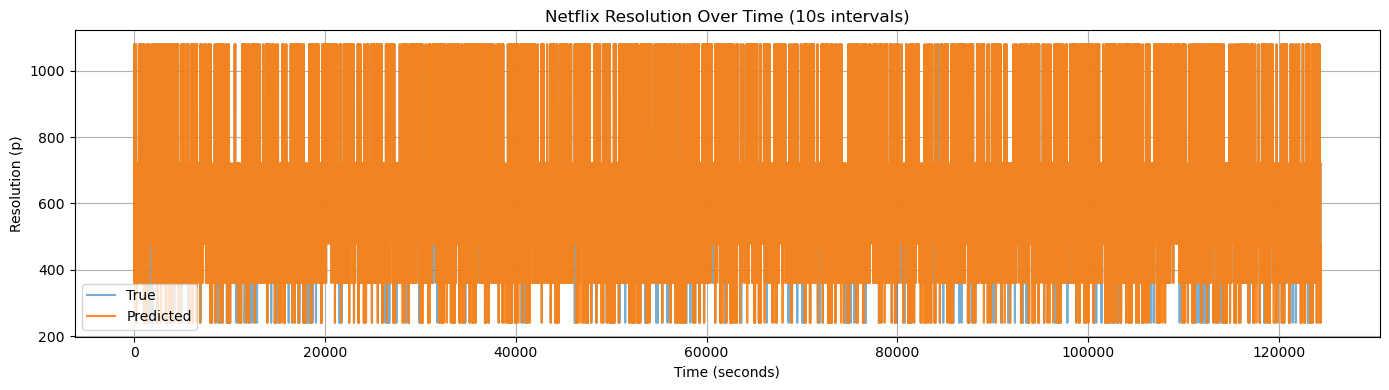

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.step(t, y_test, where="post", label="True", alpha=0.6)
plt.step(t, y_pred, where="post", label="Predicted", alpha=0.9)
plt.xlabel("Time (seconds)")
plt.ylabel("Resolution (p)")
plt.title("Netflix Resolution Over Time (10s intervals)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [64]:
out = pd.DataFrame({
    "time_s": t,
    "y_true": y_test.values if hasattr(y_test, "values") else y_test,
    "y_pred": y_pred
})

print(out.head(20))   


    time_s  y_true  y_pred
0        0     480     480
1       10    1080    1080
2       20    1080    1080
3       30     360     360
4       40     480     480
5       50     360     360
6       60     720     720
7       70     720     720
8       80     720     720
9       90     480     480
10     100     480     480
11     110    1080    1080
12     120     480     480
13     130     480     480
14     140     480     480
15     150     480     480
16     160     480     480
17     170     480     480
18     180     480     480
19     190     360     360


In [62]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

print("Part 3 — Accuracy:", accuracy_score(y_test, y_pred))
print("Part 3 — F1 (macro):", f1_score(y_test, y_pred, average="macro"))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))


Part 3 — Accuracy: 0.9601189997587842
Part 3 — F1 (macro): 0.9094174299666922

Classification report:
               precision    recall  f1-score   support

         240     0.7934    0.6776    0.7310       425
         360     0.9060    0.8695    0.8874      1119
         480     0.9716    0.9836    0.9776      7372
         720     0.9609    0.9674    0.9642      2364
        1080     0.9870    0.9870    0.9870      1157

    accuracy                         0.9601     12437
   macro avg     0.9238    0.8970    0.9094     12437
weighted avg     0.9590    0.9601    0.9593     12437



### Final Thoughts
The final model, a HistGradientBoostingClassifier, reached about 96% accuracy and a macro F1 score of 0.91 on the test set. It handled the main resolution levels (480p, 720p, 1080p) very well, with strong precision and recall across the board. The 240p class was harder to predict, which isn’t surprising since it makes up a small portion of the data.
The features came from 10-second traffic windows, including chunk size statistics and a segment rate feature. 
The results look good overall. However, I also didn’t spend a lot of time on feature selection or deep hyperparameter tuning, so there’s probably room to improve the model further. Even so, it does a solid job at inferring resolution from traffic patterns.